<a href="https://colab.research.google.com/github/gmarcelo94/sn-AI-ke/blob/main/SnakesCode_Sketch_v3_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
from random import seed
from random import randint
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
# With GitHub there is no need for Drive mounting
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/gmarcelo94/sn-AI-ke

fatal: destination path 'sn-AI-ke' already exists and is not an empty directory.


In [ ]:
path = "sn-AI-ke/Venomous" # Once cloned the repository is available localy and the path point to the folder of interest

# Set-up Snake identification and Snake Antivenom dataframes:

In [ ]:
df_snakes = pd.read_excel (r'sn-AI-ke/Snake info.xlsx', sheet_name='Most Venomous Snakes')
print (df_snakes.head(6))
print(df_snakes.shape[0])
print(df_snakes.shape[1])

        Common_Name     Scientific_Name Antivenom Picture  \
0        King Cobra  Ophiophagus hannah         Y       Y   
1      Common Krait  Bungarus caeruleus         Y       Y   
2   Russell's Viper     Daboia russelii         Y       Y   
3      Indian Cobra           Naja naja         Y       Y   
4  Saw-Scaled Viper     Echis carinatus         Y       Y   
5    Monocled Cobra       Naja kaouthia         Y       Y   

   Impacted_Population_2020  Dangerousness_Index  \
0              1.961055e+09                  5.0   
1              1.764954e+09                  4.0   
2              1.693712e+09                  4.5   
3              1.656813e+09                  4.0   
4              1.462120e+09                  3.5   
5              9.793714e+08                  3.5   

                                           Countries  
0  Bangladesh, Bhutan, Brunei, Cambodia, China, H...  
1      Bangladesh, India, Nepal, Pakistan, Sri Lanka  
2  Bangladesh, Bhutan, India, Nepal, Pakis

In [ ]:
df_antivenoms = pd.read_excel (r'sn-AI-ke/Snake info.xlsx', sheet_name='Antivenoms WHO database') #https://github.com/gmarcelo94/sn-AI-ke/blob/main/Snake%20info.xlsx?raw=true
print (df_antivenoms.head(6))
print(df_antivenoms.shape[0])
print(df_antivenoms.shape[1])

      Scientific_Name                                Antivenom  \
0  Ophiophagus hannah  Neuro-polyvalent snake antivenom (QSMI)   
1  Ophiophagus hannah              King cobra antivenin (QSMI)   
2  Bungarus caeruleus        Snake Venom Antiserum I.P. (Asia)   
3  Bungarus caeruleus               Snake venom antiserum I.P.   
4  Bungarus caeruleus   Polyvalent Anti Snake Venom Serum I.P.   
5  Bungarus caeruleus        Polyvalent Snake Antivenin (Asia)   

                                   Manufacturer_Name Manufacturer_Country  \
0                  Queen Saovabha Memorial Institute             Thailand   
1                  Queen Saovabha Memorial Institute             Thailand   
2                               VINS Bioproducts Ltd                India   
3              Premium Serums and Vaccines Pvt. Ltd.                India   
4  King Institute of Preventative Medicine and Re...                India   
5                               Biological E Limited                India  

# Data Preprocessing:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
# Here each dataset is created by fetching the data from the directory Venomous, inside the sn-AI-ke reporsitory
# There is no longer need to have the folder locally and unzipped as it can fetch directly from GitHub

ds_train = tf.keras.utils.image_dataset_from_directory(
    path, #'/content/drive/MyDrive/SnakeTeam_SamsungAI/Venomous.zip',
    labels =  'inferred',
    label_mode = "int",    #int ou string
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = "training",
)


val_ds= tf.keras.utils.image_dataset_from_directory(
    path, #'/content/drive/MyDrive/SnakeTeam_SamsungAI/Venomous.zip (Unzipped Files)/Venomous',
    labels =  'inferred',
    label_mode = "int",    #int ou string
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = 0.3,
    subset = "validation",
)

# Splitting of above val_ds into final validation and test datased (ds_val & ds_test)
l = len(val_ds)
ratio = int(0.3*l)
# print(ratio)
ds_test = val_ds.take(ratio)
ds_val = val_ds.skip(ratio)

Found 1151 files belonging to 6 classes.
Using 806 files for training.
Found 1151 files belonging to 6 classes.
Using 345 files for validation.


In [ ]:
print('Batches for training -->', ds_train.cardinality())
print('Batches for testing -->', ds_test.cardinality())
print('Batches for validating -->', ds_val.cardinality())

Batches for training --> tf.Tensor(26, shape=(), dtype=int64)
Batches for testing --> tf.Tensor(3, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(8, shape=(), dtype=int64)


In [ ]:
class_names = np.array(ds_train.class_names)
print(class_names)

['Common Krait' 'Indian Cobra' 'King Cobra' 'Monocled Cobra'
 "Russell's Viper" 'Saw-scaled Viper']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
ds_train = ds_train.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
ds_val = ds_val.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
ds_test = ds_test.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
for image_batch2, labels_batch2 in ds_test:
  print(image_batch2.shape)
  print(labels_batch2.shape)
  break

(32, 224, 224, 3)
(32,)


# Fetch Feature Vector model:

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" # 224x224
mobilenet_100_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_160/feature_vector/5" # 160x160
mobilenet_075_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_075_160/feature_vector/5" # 160x160
mobilenet_050_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_192/feature_vector/5" # 192x192 
mobilenet_035_v2 = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_160/feature_vector/5" # 160x160
mobilenet_100_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5" # 224x224
mobilenet_small_100_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5" # 224x224
mobilenet_small_075_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5" # 224x224
mobilenet_large_100_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5" # 224x224
mobilenet_large_075_v3 = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5" # 224x224

inception_v2 = "https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5" # 224x224
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4" # 299x299

restnet_v2 = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5" # 224x224

efficientnet_b0 ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficientnet_v2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2" # 240x240

amoebanet_a = "https://tfhub.dev/google/imagenet/amoebanet_a_n18_f448/feature_vector/1" # 331x331

pnasnet_5 = "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/5" # 331x331

nasnet_a_large = "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/5" # 331x331
nasnet_mobile = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5" # 224x224


feature_extractor_model = mobilenet_small_100_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

# Feature Extractor Layer:

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


# Data Augmentation - On-the-fly model:

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomContrast(factor=(0.5, 0.8), seed=123),
  layers.RandomFlip("horizontal_and_vertical", seed=123),
  layers.RandomRotation(factor=(0.125, 0.25), fill_mode='nearest', seed=123), 
  layers.RandomZoom(height_factor=(0.2, 0.5), width_factor=(0.2, 0.5), seed=123),
  layers.RandomTranslation(0.3, 0.3, fill_mode='nearest', interpolation='bilinear', seed=123),
])

# Sn{AI}ke model with attached head, data augmentation and classification layers:

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    data_augmentation,
    feature_extractor_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes)
])

# model.summary()

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 6])

# Model training and Performance visualization:

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [ ]:
NUM_EPOCHS = 20

history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/20
26/26 [==============================] - 158s 6s/step - loss: 1.9206 - acc: 0.3263 - val_loss: 1.3833 - val_acc: 0.5020
Epoch 2/20
26/26 [==============================] - 166s 6s/step - loss: 1.4740 - acc: 0.4752 - val_loss: 1.0769 - val_acc: 0.6185
Epoch 3/20
26/26 [==============================] - 164s 6s/step - loss: 1.2640 - acc: 0.5496 - val_loss: 0.9986 - val_acc: 0.6586
Epoch 4/20
26/26 [==============================] - 169s 7s/step - loss: 1.1437 - acc: 0.5757 - val_loss: 0.9231 - val_acc: 0.6747
Epoch 5/20
26/26 [==============================] - 168s 7s/step - loss: 1.1799 - acc: 0.5732 - val_loss: 0.9360 - val_acc: 0.6707
Epoch 6/20
26/26 [==============================] - 160s 6s/step - loss: 1.0137 - acc: 0.6203 - val_loss: 0.8925 - val_acc: 0.6827
Epoch 7/20
26/26 [==============================] - 168s 7s/step - loss: 0.9830 - acc: 0.6365 - val_loss: 0.9075 - val_acc: 0.6707
Epoch 8/20
26/26 [==============================] - 168s 7s/step - loss: 0.9267 - a

Note: 
A train_acc and val_acc close to each other is a sign of a good model (with augmentation it gets better);
Dropout reduces proximity bias and prevents overfitting.

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

# Check Predictions:

Obtain the ordered list of class names from the model predictions:

In [ ]:
predicted_batch = model.predict(image_batch) #image_batch
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)
print(predicted_id)

In [ ]:
print(labels_batch)

Plot the model predictions:

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  if tf.cast(predicted_id[n], tf.int32)==labels_batch[n]:
    plt.title(predicted_label_batch[n].title(), {'color' : 'green'})
  else:
    plt.title(predicted_label_batch[n].title(), {'color' : 'red'})
  plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions")

# Model Performance on Test Dataset:

Use Test dataset to evaluate the model predictions and accuracy.

In [ ]:
predicted_batch2 = model.predict(image_batch2) #image_batch
predicted_id2 = tf.math.argmax(predicted_batch2, axis=-1)
predicted_label_batch2 = class_names[predicted_id2]

print(predicted_label_batch2)
print(tf.cast(predicted_id2, tf.int32))

In [ ]:
print(labels_batch2)

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch2[n])
  if tf.cast(predicted_id2[n], tf.int32)==labels_batch2[n]:
    plt.title(predicted_label_batch2[n].title(), {'color' : 'green'})
  else:
    plt.title(predicted_label_batch2[n].title(), {'color' : 'red'})
  plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions")


In [ ]:
score = model.evaluate(ds_test, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

# Single Image Prediction, Model Evaluation & Linked Carachteristics:

(Tested image from the Test Dataset)

In [ ]:
# generate some integers
rnum = randint(0, 31)
print(rnum)

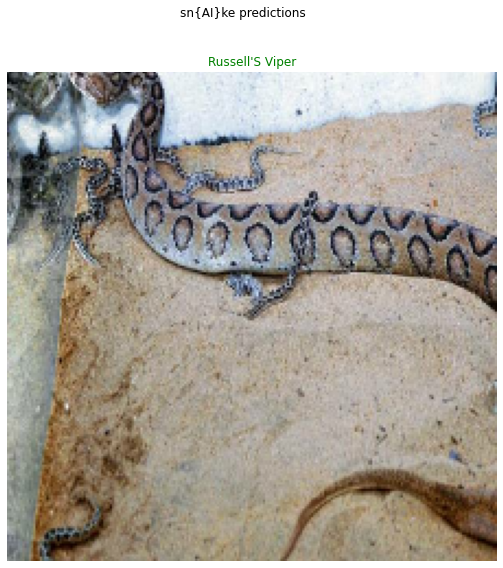

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

# plt.subplot(6,5,1+1)
plt.imshow(image_batch2[rnum])
if tf.cast(predicted_id2[rnum], tf.int32)==labels_batch2[rnum]:
  plt.title(predicted_label_batch2[rnum].title(), {'color' : 'green'})
else:
  plt.title(predicted_label_batch2[rnum].title(), {'color' : 'red'})
plt.axis('off')
_ = plt.suptitle("sn{AI}ke predictions")

In [ ]:
sci_name=[]
antivenom_info=[]
country_info=[]
k = 0

if tf.cast(predicted_id2[rnum], tf.int32)==labels_batch2[rnum]:
  print(f'Your snake was correctly identified!')
  for i in range(df_snakes.shape[0]):
     if df_snakes.iat[i,0] == predicted_label_batch2[rnum]:
       sci_name=df_snakes.iat[i,1]
       for j in range(df_antivenoms.shape[0]):
        if sci_name == df_antivenoms.iat[j,0]:
          antivenom_info.append(df_antivenoms.iat[j,1])
          country_info.append(df_antivenoms.iat[j,3])
          k += 1

  print(f"Your snake's scientific name is \033[3m {sci_name} \033[0m")
  print(f"And these are the available antivenoms:")
  for l in range(len(antivenom_info)):
    print(f"\t * {antivenom_info[l] : <40} \t\t- {country_info[l]: ^40}")

else:
  print(f'No matching snake in database named {predicted_label_batch2[rnum]}')
  print(f'WARNING: No available antivenom!')


Your snake was correctly identified!
Your snake's scientific name is  Daboia russelii 
And these are the available antivenoms:
	 * Snake Venom Antiserum (Polyvalent)       		-                  India                  
	 * Polyvalent Snake Antivenin (Asia)        		-                  India                  
	 * Snake antivenin I.P. (Asia)              		-                  India                  
	 * Polyvalent Antisnake Venom Serum         		-                 Pakistan                
	 * Snake Venom Antiserum I.P. (Asia)        		-                  India                  
	 * Polyvalent Anti Snake Venom Serum I.P.   		-                  India                  
	 * Snake venom antiserum I.P.               		-                  India                  


# Outsourced Image:

In [ ]:
# Setup camera
cap = cv2.VideoCapture(0)
while True:
	ret, frame = cap.read()
	cv2.imshow('WebCam', frame)
	if cv2.waitKey(1) == ord('q'):
		break

cap.release()
cv2.destroyAllWindows()

# Read logo and resize
logo = cv2.imread('image.png')
size = 224
logo = cv2.resize(logo, (size, size))

img2gray = cv2.cvtColor(logo, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(img2gray, 1, 224, cv2.THRESH_BINARY)

cv2.imshow('WebCam', frame)
if cv2.waitKey(1) == ord('q'):
	break


cap.release()
cv2.destroyAllWindows()




DisabledFunctionError: ignored